<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
</center>

# [Projet machine learning](Projet-ML)

## Objectifs : 
<span style="color:  rgb(139, 0, 0)">**Notre projet consiste à analyser et faire des prédictions sur un jeu de données qui fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures de la condition physique des membres d’une salle de sport. Il y a deux objectifs principales pour ce projet :  Le premier objectif est de faire une analyse exploratoire des données pour bien cerner nos données. Dans un second temps, on effectuera deux modélisations avec la prédiction de calories brulées et du niveau d'expérience.**</span>

## Table des matières
1. [Analyse explorative des données (langage R)](#analyse-données)
   - Description général (natures des variables, encodages ...)
   - Analyse descriptive unidimensionnelle et bidimensionnelle
   - ACP des différentes variables
2. [Modélisation (langage R et python)](#modélisation)
   - Prédiction des calories brulées
   - Prédiction du niveau d'expérience
# 1. Analyse explorative des donées (langage R)
Cette partie se fera uniquement en R, l'analyse est dans l'autre notebook.

# 2. Modélisation (langage python)

# 2.1 Prédiction des calories brulées 

## 2.1.1 Ajustement des données 

In [18]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
data=pd.read_csv("gym_members_exercise_tracking.csv",sep=",",header=0)
data.head()
data.dtypes
#On doit vérifier si les types sont bon, par exemple on va interpréter Experience_Level et Workout_Frequency comme des variables qualitatives avec des modalités. 

Age                                int64
Gender                            object
Weight (kg)                      float64
Height (m)                       float64
Max_BPM                            int64
Avg_BPM                            int64
Resting_BPM                        int64
Session_Duration (hours)         float64
Calories_Burned                  float64
Workout_Type                      object
Fat_Percentage                   float64
Water_Intake (liters)            float64
Workout_Frequency (days/week)      int64
Experience_Level                   int64
BMI                              float64
dtype: object

In [ ]:
#Transformation de nos données au bon format voulu
data["Gender"]=pd.Categorical(data["Gender"],ordered=False)
data["Workout_Type"]=pd.Categorical(data["Workout_Type"],ordered=False)
data["Workout_Frequency (days/week)"]=pd.Categorical(data["Workout_Frequency (days/week)"],ordered=False)
data["Experience_Level"]=pd.Categorical(data["Experience_Level"],ordered=False)
data.dtypes

Age                                 int64
Gender                           category
Weight (kg)                       float64
Height (m)                        float64
Max_BPM                             int64
Avg_BPM                             int64
Resting_BPM                         int64
Session_Duration (hours)          float64
Calories_Burned                   float64
Workout_Type                     category
Fat_Percentage                    float64
Water_Intake (liters)             float64
Workout_Frequency (days/week)    category
Experience_Level                 category
BMI                               float64
dtype: object

In [ ]:
data.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,49.840000


On va maintenant récupérer les variables explicatives en transformant les données de manière a pouvoir les utiliser en régression et classification. 

In [21]:
#Variables explicatives
################Variables qualitatives
dataDum=pd.get_dummies(data[["Gender","Workout_Type","Workout_Frequency (days/week)","Experience_Level"]]) 
# pour transformer des variables qualitatives en variables indicatrices, 
# chaque valeur unique de la variable qualitative devient une colonne distincte dans le DataFrame résultant

################Variables quantitatives
dataQuant=data[["Age","Weight (kg)","Height (m)","Max_BPM","Avg_BPM","Resting_BPM","Session_Duration (hours)","Fat_Percentage","Water_Intake (liters)","BMI"]] #Varaibles quanti

# Concaténation des variables explicatives
dfC=pd.concat([dataDum,dataQuant],axis=1)
dfC.head()



,Gender_Female,Gender_Male,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga,Workout_Frequency (days/week)_2,Workout_Frequency (days/week)_3,Workout_Frequency (days/week)_4,Workout_Frequency (days/week)_5,...,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),BMI
0,False,True,False,False,False,True,False,False,True,False,...,56,88.3,1.71,180,157,60,1.69,12.6,3.5,30.20
1,True,False,False,True,False,False,False,False,True,False,...,46,74.9,1.53,179,151,66,1.30,33.9,2.1,32.00
2,True,False,True,False,False,False,False,False,True,False,...,32,68.1,1.66,167,122,54,1.11,33.4,2.3,24.71
3,False,True,False,False,True,False,False,True,False,False,...,25,53.2,1.70,190,164,56,0.59,28.8,2.1,18.41
4,False,True,False,False,True,False,False,True,False,False,...,38,46.1,1.79,188,158,68,0.64,29.2,2.8,14.39


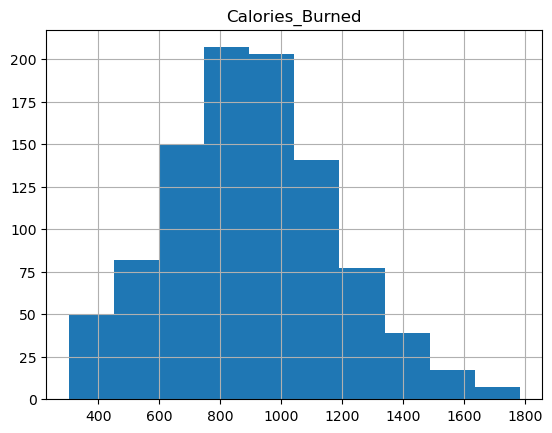

In [22]:
#Variables à prédire/expliquer 
YC=data[["Calories_Burned"]]
YC.hist()
plt.show()

In [25]:
from sklearn.model_selection import train_test_split  
Lignes_Data=data.shape[0]
Colonnes_Data=data.shape[1]
Nbre_Element=data.size
Xc_train,Xc_test,YC_train,YC_test=train_test_split(dfC,YC,test_size=0.2,random_state=11) #test_size=0.2 indique qu'on prend 20%


On va standardiser nos données, indispensables pour une utilisation efficase des algorithmes non linéaires : SVM, réseaux de neuronnes etc ...

In [26]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()  
scaler.fit(Xc_train)  
XC_train = scaler.transform(Xc_train)  
# Meme transformation sur le test
XC_test = scaler.transform(Xc_test)

## 2.2 Prévisions par modèles linéaires 

In [28]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

regLasso = linear_model.Lasso()
regLasso.fit(XC_train,YC_train)
prev=regLasso.predict(XC_test)
print("MSE=",mean_squared_error(YC_test,prev))

MSE= 1585.529698494295


In [ ]:
from sklearn.metrics import r2_score
print("R2=",r2_score(YC_test,prev))

R2= 0.9813767896831493


In [33]:
from sklearn.model_selection import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.4,0.5,1,1.2,1.3,1.4,1.5]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(XC_train, YC_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Meilleur R2 = 0.977484, Meilleur paramètre = {'alpha': 1.3}
